# 一、概述
## 1.网络架构模型
* 抽象出可能的分类类别，记为o1、o2、o3，分析出特征数，记为w1、w2、w3，也即预测公式为：
<mark>o1=x1*w1+x2*w2+x3*w3+b1
</mark>
* 单层神经网络
* 概率表示：
  $\hat{y}$ = exp(o<sub>j</sub>)/
  $\sum_{i=0}^n$ exp(o<sub>k</sub>)

## 2.读取数据图像集
### 使用的函数
* torchvision.datasets.FashionMNIST：下载图像库用于后续分类算法
* _:用作一个名字，来表示某个变量是临时的或无关紧要的。
* axes.flatten():将子图平展化，以此可以根据a[i]来访问各个子图
* enumerate()：将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
* zip():将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。

In [3]:
# 函数实例
seq = ['one', 'two', 'three']
for i, element in enumerate(seq):
    print (i,element)

0 one
1 two
2 three


In [4]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
trans=transforms.ToTensor()
# 下载一个训练集
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
# 下载一个测试集
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [6]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

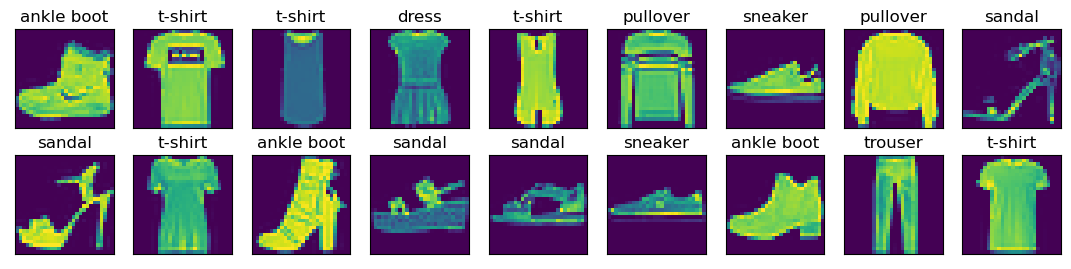

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

# 三、准备工作

In [3]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 2

# 返回批量batch_size的数据
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]# 一个函数的列表
    if resize:
        trans.insert(0, transforms.Resize(resize))# 函数功能增加一项
    trans = transforms.Compose(trans)# 组合图像操作
    # 与上面类似，下载图像集
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                        ),# 使用几个进程进行加载，默认为0
            data.DataLoader(mnist_test, batch_size, shuffle=False,# 代表主线程加载
                            ))

# 四、深度学习框架解决
## 调用函数部分
* nn.Flatten(n)：保留指定第n维，将其余维度拍成单独一维，默认情况下只保留第0维
* 原始数据集样本均为28*28的图像，每个像素位置都可以看作一个输入特征，因此将其展平为长度为784的向量，将原本的三维数据压缩为二维的线性回归问题
* net.apply：将函数递归地作用在每一个层上
* nn.CrossEntropyLoss：本质是$H(p,q)=-\sum(p(x)logq(x)) $ 
  Pytorch中CrossEntropyLoss()函数的主要是将softmax-log-NLLLoss合并到一块得到的结果。
    1. Softmax后的数值都在0~1之间，所以ln之后值域是负无穷到0。
    2. 然后将Softmax之后的结果取log，将乘法改成加法减少计算量，同时保障函数的单调性 。
    3. NLLLoss的结果就是把上面的输出与Label对应的那个值拿出来
## 自定义函数部分
* accurary(y_hat,y):

In [1]:
from torch import nn
import torch
batch_size=256
train_iter,test_iter=load_data_fashion_mnist(batch_size)
next(iter(train_iter))

e:\coding_setting\Miniconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'load_data_fashion_mnist' is not defined

In [5]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

NameError: name 'nn' is not defined

In [12]:
loss = nn.CrossEntropyLoss(reduction='none')

In [13]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [52]:
def accuracy(y_hat, y):  #@save
    """计算预测正确率"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())/y.shape[0]

In [47]:
def evaluate_accuracy(net, data_iter):  #@save
    right_count,all_count=0.0,0
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    with torch.no_grad():
        for X, y in data_iter:
            right_count+=accuracy(net(X),y)
            all_count+=y.shape[0]
    return right_count/all_count

In [68]:
def train(net,num_epochs,train_iter,test_iter,loss,trainer):
    for i in range(num_epochs):
        for X,y in train_iter:
            y_hat=net(X)
            print(y_hat[0])
            l=loss(y_hat,y)
            trainer.zero_grad()
            l.mean().backward()
            trainer.step()
        one_accuracy=accuracy(y_hat,y)
        print(f'第{i}次测试,损失率为{l.mean()},准确率为{one_accuracy}')

In [69]:
num_epochs = 10
train(net, num_epochs,train_iter,test_iter,loss,trainer)

tensor([-4.6519, -5.2500, -5.3606, -6.5443, -5.7558,  7.9442, -2.2232,  7.0589,
         1.3109, 13.2507], grad_fn=<SelectBackward0>)
tensor([  8.0420,   0.0954,   7.4404,   0.4425,   1.9157, -10.4651,   9.7516,
        -15.0391,   4.6793,  -6.2374], grad_fn=<SelectBackward0>)
tensor([-4.3382, -6.6011, -4.6384, -7.1932, -4.9446,  6.7571, -1.8546,  7.8437,
         0.4844, 14.4141], grad_fn=<SelectBackward0>)
tensor([-2.8954, -4.8587, -0.9973, -2.9527, -2.5611,  5.7077, -0.1129,  0.0462,
         2.2238,  6.3029], grad_fn=<SelectBackward0>)
tensor([  8.8673,   3.5072,   3.2094,   8.4638,   2.2138, -19.0687,   6.7655,
         -7.7124,   1.5484,  -7.2300], grad_fn=<SelectBackward0>)
tensor([ 2.0689,  1.0135,  6.4940,  1.4525,  4.8320, -5.0257,  4.5779, -7.1787,
         0.5923, -8.8207], grad_fn=<SelectBackward0>)
tensor([  5.0760,  12.7585,   4.6616,   5.1134,   4.2771, -14.9668,  -2.2437,
         -3.2670,  -1.1569,  -9.6130], grad_fn=<SelectBackward0>)
tensor([  2.0021,  12.3592,   1.